<a href="https://colab.research.google.com/github/gennettezimmer/ESG_Analytics/blob/master/GOZ_ESG_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages and Mount Drives

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statistics as st
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ESG_DATA = '/content/drive/MyDrive/Portfolio_Projects/MSCI_esg_2022.xlsx'

In [5]:
ESG = pd.read_excel(ESG_DATA, sheet_name="MSCI_esg")
ESG['Rating_list'] = ESG['Rating_list'].apply(str)
ESG.drop(['Ticker'], axis=1, inplace=True)
CC = pd.read_excel(ESG_DATA, sheet_name="country_codes")
CC.drop(['CT_3','CT_Code','ISO_Entry_3166-2','intermediate_region','region_code','sub_region_code','intermediate_region_code'], axis=1, inplace=True)
CC.rename(columns = {'name':'Country', 'region':'Region', 'sub_region':'Sub_Region'}, inplace = True)

In [7]:
GDP = pd.read_excel(ESG_DATA, sheet_name="GDP")
GDP.drop(['Country'], axis=1, inplace=True)
GDP['IMF_GDP_Year'] = GDP['IMF_GDP_Year'].apply(str)
GDP['UN_GDP_Year'] = GDP['UN_GDP_Year'].apply(str)
GDP['World_Bank_GDP_Year'] = GDP['World_Bank_GDP_Year'].apply(str)
GDP['IMF_GDP_Year'] = GDP['IMF_GDP_Year'].str[:-2]
GDP['UN_GDP_Year'] = GDP['UN_GDP_Year'].str[:-2]
GDP['World_Bank_GDP_Year'] = GDP['World_Bank_GDP_Year'].str[:-2]

# Exploratory Data Analysis (EDA)

In [8]:
#Look up ESG info
ESG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15646 entries, 0 to 15645
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company_Name         15646 non-null  object 
 1   CT_2                 15644 non-null  object 
 2   Sector               15646 non-null  object 
 3   Subsector            14860 non-null  object 
 4   Overall_ESG_RATING   15646 non-null  object 
 5   Rating_list          15646 non-null  object 
 6   Overall_ESG_SCORE    15646 non-null  float64
 7   Environmental_SCORE  15646 non-null  float64
 8   Social_SCORE         15646 non-null  float64
 9   Governance_SCORE     15646 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.2+ MB


In [9]:
# Fill in null subsectors with sector
ESG['Subsector'] = np.where(ESG['Subsector'].isnull(), ESG['Sector'], ESG['Subsector'])

In [10]:
# Find null CT_2
ESG[ESG['CT_2'].isnull()]

,Company_Name,CT_2,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE
1298,First National Bank of Namibia Limited,NaN,Banks,Diversified Banks,A,3,7.0,10.0,4.6,6.4
5628,Standard Bank Namibia Limited,NaN,Banks,Diversified Banks,AA,2,7.9,6.8,4.0,5.3


In [11]:
# Remove both rows for banks in Namibia
ESG = ESG.loc[ESG['Company_Name'] != "First National Bank of Namibia Limited"]
ESG = ESG.loc[ESG['Company_Name'] != "Standard Bank Namibia Limited"]

In [12]:
# Confirm ESG null rows are deleted
ESG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15645
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company_Name         15644 non-null  object 
 1   CT_2                 15644 non-null  object 
 2   Sector               15644 non-null  object 
 3   Subsector            15644 non-null  object 
 4   Overall_ESG_RATING   15644 non-null  object 
 5   Rating_list          15644 non-null  object 
 6   Overall_ESG_SCORE    15644 non-null  float64
 7   Environmental_SCORE  15644 non-null  float64
 8   Social_SCORE         15644 non-null  float64
 9   Governance_SCORE     15644 non-null  float64
dtypes: float64(4), object(6)
memory usage: 1.3+ MB


In [13]:
# Get info for country code
CC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     249 non-null    object 
 1   CT_2        248 non-null    object 
 2   Region      248 non-null    object 
 3   Sub_Region  248 non-null    object 
 4   EU          26 non-null     float64
 5   G20         42 non-null     float64
 6   OPEC        14 non-null     float64
 7   WTO         163 non-null    float64
 8   PA          194 non-null    float64
 9   UN          193 non-null    float64
 10  NATO        30 non-null     float64
dtypes: float64(7), object(4)
memory usage: 21.5+ KB


In [14]:
# Fill NA's for affiliation groups
CC['EU'] = CC['EU'].fillna(0)
CC['G20'] = CC['G20'].fillna(0)
CC['OPEC'] = CC['OPEC'].fillna(0)
CC['WTO'] = CC['WTO'].fillna(0)
CC['PA'] = CC['PA'].fillna(0)
CC['UN'] = CC['UN'].fillna(0)
CC['NATO'] = CC['NATO'].fillna(0)

In [15]:
# Locate null CT value
CC[CC['CT_2'].isnull()]

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO
151,Namibia,NaN,Africa,Sub-Saharan Africa,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [16]:
# Remove null row for Namibia
CC = CC.loc[CC['Country'] != "Namibia"]

In [17]:
# Locate null region value
CC[CC['Region'].isnull()]

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO
8,Antarctica,AQ,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Locate null sub-region value
CC[CC['Sub_Region'].isnull()]

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO
8,Antarctica,AQ,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Remove null row for Antarctica
CC = CC.loc[CC['Country'] != "Antarctica"]

In [20]:
# Review info for country code
CC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 248
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     247 non-null    object 
 1   CT_2        247 non-null    object 
 2   Region      247 non-null    object 
 3   Sub_Region  247 non-null    object 
 4   EU          247 non-null    float64
 5   G20         247 non-null    float64
 6   OPEC        247 non-null    float64
 7   WTO         247 non-null    float64
 8   PA          247 non-null    float64
 9   UN          247 non-null    float64
 10  NATO        247 non-null    float64
dtypes: float64(7), object(4)
memory usage: 23.2+ KB


In [21]:
ESG.head(2)

,Company_Name,CT_2,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE
0,0921706 BC LTD,CA,Telecommunication Services,Wireless Telecommunication Services,A,3,6.6,10.0,7.4,2.7
1,"1000 AUAHI, LLC",US,Real Estate Development & Diversified Activities,Real Estate Development,A,3,6.8,6.1,4.1,6.9


In [22]:
CC.head(2)

,Country,CT_2,Region,Sub_Region,EU,G20,OPEC,WTO,PA,UN,NATO
0,Afghanistan,AF,Asia,Southern Asia,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,Åland Islands,AX,Europe,Northern Europe,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Merge ESG data with Country Code information
ESG_CC = pd.merge(ESG, CC, on='CT_2')

In [24]:
# Reorganize data
cats = list(ESG_CC.select_dtypes(include=['object']).columns)
nums = list(ESG_CC.select_dtypes(exclude=['object']).columns)

In [25]:
print(f'categorical variables:  {cats}')

categorical variables:  ['Company_Name', 'CT_2', 'Sector', 'Subsector', 'Overall_ESG_RATING', 'Rating_list', 'Country', 'Region', 'Sub_Region']


In [26]:
print(f'numerical variables:  {nums}')

numerical variables:  ['Overall_ESG_SCORE', 'Environmental_SCORE', 'Social_SCORE', 'Governance_SCORE', 'EU', 'G20', 'OPEC', 'WTO', 'PA', 'UN', 'NATO']


In [27]:
ESG_CC = pd.concat((ESG_CC[cats], ESG_CC[nums]), axis=1)

In [28]:
ESG_CC = ESG_CC[['Country', 'Region', 'CT_2', 'Sub_Region','Company_Name', 'Sector', 'Subsector', 'Overall_ESG_RATING', 'Rating_list', 'Overall_ESG_SCORE', 'Environmental_SCORE', 'Social_SCORE', 'Governance_SCORE', 'EU', 'G20', 'OPEC', 'WTO', 'PA', 'UN', 'NATO']]

In [29]:
ESG_CC.head(2)

,Country,Region,CT_2,Sub_Region,Company_Name,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE,EU,G20,OPEC,WTO,PA,UN,NATO
0,Canada,Americas,CA,Northern America,0921706 BC LTD,Telecommunication Services,Wireless Telecommunication Services,A,3,6.6,10.0,7.4,2.7,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1,Canada,Americas,CA,Northern America,ALIMENTATION COUCHE-TARD INC,Retail - Food & Staples,Food Retail,A,3,6.5,4.7,4.7,5.6,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [30]:
ESG_CC.shape

(15644, 20)

In [31]:
# Combined ESG_CC table info
ESG_CC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15643
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              15644 non-null  object 
 1   Region               15644 non-null  object 
 2   CT_2                 15644 non-null  object 
 3   Sub_Region           15644 non-null  object 
 4   Company_Name         15644 non-null  object 
 5   Sector               15644 non-null  object 
 6   Subsector            15644 non-null  object 
 7   Overall_ESG_RATING   15644 non-null  object 
 8   Rating_list          15644 non-null  object 
 9   Overall_ESG_SCORE    15644 non-null  float64
 10  Environmental_SCORE  15644 non-null  float64
 11  Social_SCORE         15644 non-null  float64
 12  Governance_SCORE     15644 non-null  float64
 13  EU                   15644 non-null  float64
 14  G20                  15644 non-null  float64
 15  OPEC                 15644 non-null 

In [32]:
# Count of unique values
ESG_CC.nunique(axis=0)

Country                  108
Region                     5
CT_2                     108
Sub_Region                15
Company_Name           15558
Sector                    69
Subsector                192
Overall_ESG_RATING         7
Rating_list                7
Overall_ESG_SCORE        117
Environmental_SCORE      101
Social_SCORE             101
Governance_SCORE          88
EU                         2
G20                        2
OPEC                       2
WTO                        2
PA                         2
UN                         2
NATO                       2
dtype: int64

In [33]:
# Merge ESG with GDP
ESG_GDP = pd.merge(ESG_CC, GDP, on='CT_2')
ESG_GDP.drop(['EU','G20','OPEC','WTO','PA','UN','NATO'], axis=1, inplace=True)
ESG_GDP.head(3)

,Country,Region,CT_2,Sub_Region,Company_Name,Sector,Subsector,Overall_ESG_RATING,Rating_list,Overall_ESG_SCORE,Environmental_SCORE,Social_SCORE,Governance_SCORE,IMF_GDP_Estimate,IMF_GDP_Year,UN_GDP_Estimate,UN_GDP_Year,World_Bank_GDP_Estimate,World_Bank_GDP_Year
0,Canada,Americas,CA,Northern America,0921706 BC LTD,Telecommunication Services,Wireless Telecommunication Services,A,3,6.6,10.0,7.4,2.7,2221218.0,2022,1644037.0,2020,1643408.0,2020
1,Canada,Americas,CA,Northern America,ALIMENTATION COUCHE-TARD INC,Retail - Food & Staples,Food Retail,A,3,6.5,4.7,4.7,5.6,2221218.0,2022,1644037.0,2020,1643408.0,2020
2,Canada,Americas,CA,Northern America,ATCO LTD,Utilities,Multi-Utilities,A,3,6.1,7.1,6.2,3.8,2221218.0,2022,1644037.0,2020,1643408.0,2020


# Creating Data Frames by Country or Member Organizations

In [34]:
# Create Sub data frames for specific groups
# Group by Country
US = ESG_CC[(ESG_CC['CT_2']=='US')]
CAN = ESG_CC[(ESG_CC['CT_2']=='CA')]
UK = ESG_CC[(ESG_CC['CT_2'])=='GB']
EU = ESG_CC[(ESG_CC['EU']==1)]
OTH_CT = ESG_CC[(ESG_CC['EU']!=1) & (ESG_CC['CT_2']!='US') & (ESG_CC['CT_2']!='CA') & (ESG_CC['CT_2']!='GB')]

In [35]:
# Group by member organizations
G20 = ESG_CC[(ESG_CC['G20']==1)]
OPEC = ESG_CC[(ESG_CC['OPEC']==1)]
WTO = ESG_CC[(ESG_CC['WTO']==1)]
PA = ESG_CC[(ESG_CC['PA']==1)]
NATO = ESG_CC[(ESG_CC['NATO']==1)]
UN = ESG_CC[(ESG_CC['UN']==1)]
Non_ORG = ESG_CC[(ESG_CC['G20']!=1) & (ESG_CC['OPEC']!=1) & (ESG_CC['WTO']!=1) & (ESG_CC['PA']!=1) & (ESG_CC['NATO']!=1) & (ESG_CC['UN']!=1)]

# Descriptive Info, Median, and Mode for selected group

In [36]:
# Function to return description, median and modes for all of the scores
def describe(df):
  de = df[['Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE','Governance_SCORE']].describe().transpose()
  me = df[['Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE','Governance_SCORE']].median()
  mo = df[['Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE','Governance_SCORE']].mode().transpose()
  return print('Score Description\n',de, '\n\nScore Median\n',me, '\n\nScore Mode\n',mo)

In [37]:
# Enter desired data frame - ESG_CC for all data or one of the Groups (by country: US, CAN, UK, EU, OTH_CT, by member org: G20, OPEC, WTO, PA, NATO, UN, Non_ORG)
describe(US)

Score Description
                       count      mean       std  min  25%  50%  75%   max
Overall_ESG_SCORE    4684.0  5.104170  2.018222  0.0  3.7  5.2  6.7  10.0
Environmental_SCORE  4684.0  5.210675  2.506250  0.0  3.4  5.3  6.9  10.0
Social_SCORE         4684.0  4.491332  1.466988  0.0  3.5  4.4  5.4  10.0
Governance_SCORE     4684.0  5.200897  1.151176  0.0  4.5  5.3  6.0   8.4 

Score Median
 Overall_ESG_SCORE      5.2
Environmental_SCORE    5.3
Social_SCORE           4.4
Governance_SCORE       5.3
dtype: float64 

Score Mode
                         0
Overall_ESG_SCORE     7.0
Environmental_SCORE  10.0
Social_SCORE          4.6
Governance_SCORE      5.9



# Histograms of Scores for Selected Country(s)/Member Org Comparison

In [38]:
# Compare six countries/member organziations
def create_histogram_6(plot1_f,DF_1,grp_1,DF_2,grp_2,DF_3,grp_3,DF_4,grp_4,DF_5,grp_5,DF_6,grp_6):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig) ## Declaring 3x2 figure.

        ax1 = fig.add_subplot(specs[0, 0]) ## First Row First Column
        ax2 = fig.add_subplot(specs[0, 1]) ## First Row Second Column
        ax3 = fig.add_subplot(specs[0, 2]) ## First Row Third Column
        ax4 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax5 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums
        ax6 = fig.add_subplot(specs[1, 2]) ## Second Row Third Column

        ## First Graph - Histogram
        ax1.hist(DF_1[plot1_f], color="tab:red", )
        ax1.set_ylabel(plot1_f)
        ax1.set_title(grp_1)

        ## Second Graph - Histogram
        ax2.hist(DF_2[plot1_f], color="tab:green", )
        ax2.set_ylabel(plot1_f)
        ax2.set_title(grp_2)

        ## Third Graph - Histogram
        ax3.hist(DF_3[plot1_f], color="tab:blue", )
        ax3.set_ylabel(plot1_f)
        ax3.set_title(grp_3)

        ## Fourth Graph - Histogram
        ax4.hist(DF_4[plot1_f], color="tab:blue", )
        ax4.set_ylabel(plot1_f)
        ax4.set_title(grp_4)

        ## Fifth Graph - Histogram
        ax5.hist(DF_5 [plot1_f], color="tab:green", )
        ax5.set_ylabel(plot1_f)
        ax5.set_title(grp_5)

        ## Sixth Graph - Histogram
        ax6.hist(DF_6 [plot1_f], color="tab:red", )
        ax6.set_ylabel(plot1_f)
        ax6.set_title(grp_6)

        plt.close(fig)
        return fig

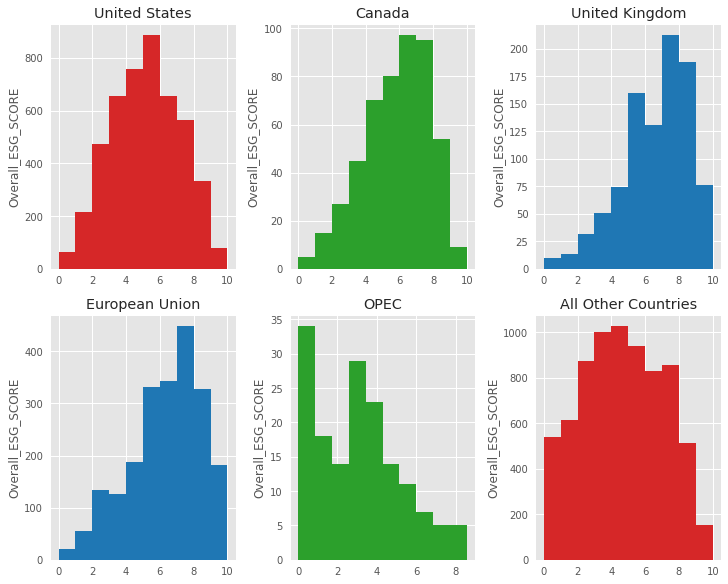

In [39]:
create_histogram_6('Overall_ESG_SCORE',US,'United States',CAN,'Canada',UK,'United Kingdom',EU,'European Union',OPEC,'OPEC', OTH_CT, 'All Other Countries')

In [40]:
# Compare four countries/member organziations
def create_histogram_4(plot1_f,DF_1,grp_1,DF_2,grp_2,DF_3,grp_3,DF_4,grp_4):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.

        ax1 = fig.add_subplot(specs[0, 0]) ## First Row First Column
        ax2 = fig.add_subplot(specs[0, 1]) ## First Row Second Column
        ax3 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax4 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums

        ## First Graph - Histogram
        ax1.hist(DF_1[plot1_f], color="tab:red", )
        ax1.set_ylabel(plot1_f)
        ax1.set_title(grp_1)

        ## Second Graph - Histogram
        ax2.hist(DF_2[plot1_f], color="tab:green", )
        ax2.set_ylabel(plot1_f)
        ax2.set_title(grp_2)

        ## Third Graph - Histogram
        ax3.hist(DF_3[plot1_f], color="tab:blue", )
        ax3.set_ylabel(plot1_f)
        ax3.set_title(grp_3)

        ## Fourth Graph - Histogram
        ax4.hist(DF_4[plot1_f], color="tab:orange", )
        ax4.set_ylabel(plot1_f)
        ax4.set_title(grp_4)

        plt.close(fig)
        return fig

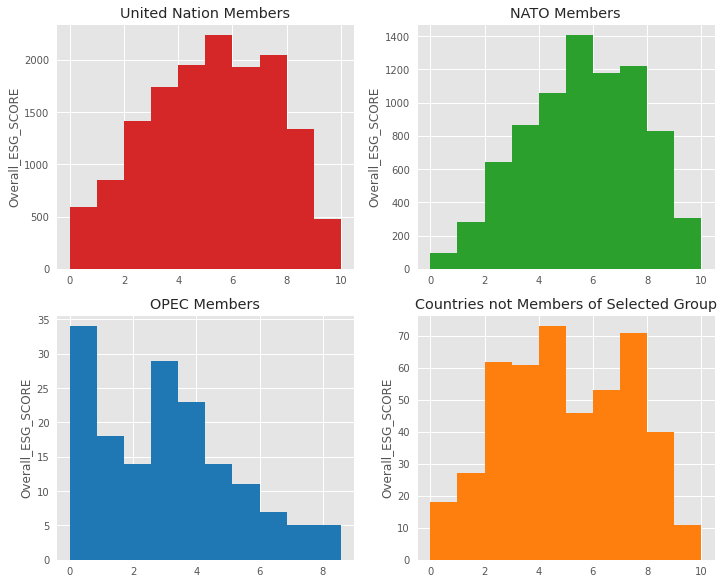

In [41]:
create_histogram_4('Overall_ESG_SCORE',UN,'United Nation Members',NATO,'NATO Members',OPEC,'OPEC Members',Non_ORG,'Countries not Members of Selected Group')

# Line Graphs for Country/Member Org Comparisons

In [42]:
def create_line_charts_6(grp_1,grp_2,grp_3,grp_4,grp_5,grp_6):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig) ## Declaring 3x2 figure.

        ax1 = fig.add_subplot(specs[0, 0]) ## First Row First Column
        ax2 = fig.add_subplot(specs[0, 1]) ## First Row Second Column
        ax3 = fig.add_subplot(specs[0, 2]) ## First Row Third Column
        ax4 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax5 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums
        ax6 = fig.add_subplot(specs[1, 2]) ## Second Row Third Column

        ## First Graph - Line Graph
        AVG_GRP_1 = grp_1.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_1 = AVG_GRP_1.add_suffix('_Score').reset_index()
        AVG_GRP_1_sorted = AVG_GRP_1.sort_values('Rating_list', ascending=False)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax1)

        ## Second Graph - Line Graph
        AVG_GRP_2 = grp_2.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_2 = AVG_GRP_2.add_suffix('_Score').reset_index()
        AVG_GRP_2_sorted = AVG_GRP_2.sort_values('Rating_list', ascending=False)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax2)

        ## Third Graph - Line Graph
        AVG_GRP_3 = grp_3.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_3 = AVG_GRP_3.add_suffix('_Score').reset_index()
        AVG_GRP_3_sorted = AVG_GRP_3.sort_values('Rating_list', ascending=False)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax3)

        ## Fourth Graph - Line Graph
        AVG_GRP_4 = grp_4.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_4 = AVG_GRP_4.add_suffix('_Score').reset_index()
        AVG_GRP_4_sorted = AVG_GRP_4.sort_values('Rating_list', ascending=False)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax4)

        ## Fifth Graph - Line Graph
        AVG_GRP_5 = grp_5.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_5 = AVG_GRP_5.add_suffix('_Score').reset_index()
        AVG_GRP_5_sorted = AVG_GRP_5.sort_values('Rating_list', ascending=False)
        AVG_GRP_5_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax5)
        AVG_GRP_5_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax5)
        AVG_GRP_5_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax5)
        AVG_GRP_5_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax5)

        ## Sixth Graph - Line Graph
        AVG_GRP_6 = grp_6.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_6 = AVG_GRP_6.add_suffix('_Score').reset_index()
        AVG_GRP_6_sorted = AVG_GRP_6.sort_values('Rating_list', ascending=False)
        AVG_GRP_6_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax6)
        AVG_GRP_6_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax6)
        AVG_GRP_6_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax6)
        AVG_GRP_6_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax6)
        
        plt.close(fig)
        return fig

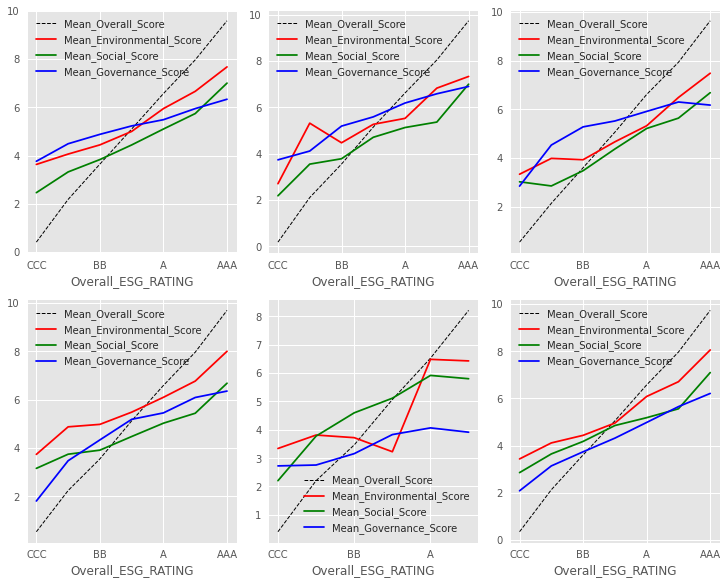

In [43]:
create_line_charts_6(US,UK,CAN,EU,OPEC,OTH_CT)

In [44]:
def create_line_charts_4(grp_1,grp_2,grp_3,grp_4):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.

        ax1 = fig.add_subplot(specs[0, 0]) ## First Row First Column
        ax2 = fig.add_subplot(specs[0, 1]) ## First Row Second Column
        ax3 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax4 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums

        ## First Graph - Line Graph
        AVG_GRP_1 = grp_1.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_1 = AVG_GRP_1.add_suffix('_Score').reset_index()
        AVG_GRP_1_sorted = AVG_GRP_1.sort_values('Rating_list', ascending=False)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax1)
        AVG_GRP_1_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax1)

        ## Second Graph - Line Graph
        AVG_GRP_2 = grp_2.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_2 = AVG_GRP_2.add_suffix('_Score').reset_index()
        AVG_GRP_2_sorted = AVG_GRP_2.sort_values('Rating_list', ascending=False)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax2)
        AVG_GRP_2_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax2)

        ## Third Graph - Line Graph
        AVG_GRP_3 = grp_3.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_3 = AVG_GRP_3.add_suffix('_Score').reset_index()
        AVG_GRP_3_sorted = AVG_GRP_3.sort_values('Rating_list', ascending=False)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax3)
        AVG_GRP_3_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax3)

        ## Fourth Graph - Line Graph
        AVG_GRP_4 = grp_4.groupby(['Rating_list','Overall_ESG_RATING']).agg(
        Mean_Overall=('Overall_ESG_SCORE', np.mean),
        Mean_Environmental=('Environmental_SCORE', np.mean),
        Mean_Social=('Social_SCORE', np.mean),    
        Mean_Governance=('Governance_SCORE', np.mean))
        AVG_GRP_4 = AVG_GRP_4.add_suffix('_Score').reset_index()
        AVG_GRP_4_sorted = AVG_GRP_4.sort_values('Rating_list', ascending=False)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Overall_Score', color='black', linestyle='dashed', linewidth=1, ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Environmental_Score', color='red', ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Social_Score', color='green', ax=ax4)
        AVG_GRP_4_sorted.plot(kind='line',x='Overall_ESG_RATING',y='Mean_Governance_Score', color='blue', ax=ax4)
        
        plt.close(fig)
        return fig

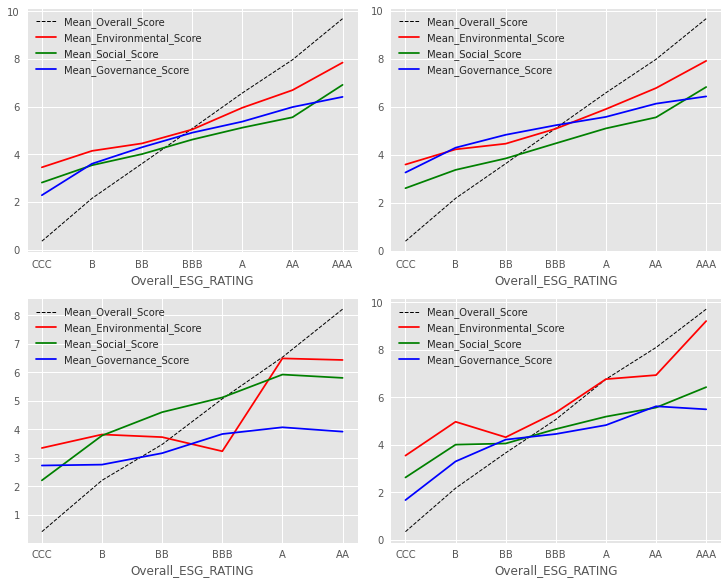

In [45]:
create_line_charts_4(UN,NATO,OPEC,Non_ORG)

# Scatter Plots

In [46]:
ESG_sorted = ESG.sort_values('Rating_list', ascending=True)


In [47]:
# Environmental to Overall scatter plot
fig = px.scatter(ESG_sorted, y="Overall_ESG_SCORE", x="Environmental_SCORE", color="Overall_ESG_RATING", size='Environmental_SCORE')
fig.show()

In [48]:
# Social to Overall scatter plot
fig = px.scatter(ESG_sorted, y="Overall_ESG_SCORE", x="Social_SCORE", color="Overall_ESG_RATING", size='Social_SCORE')
fig.show()

In [49]:
# Governance to Overall scatter plot
fig = px.scatter(ESG_sorted, y="Overall_ESG_SCORE", x="Governance_SCORE", color="Overall_ESG_RATING", size='Governance_SCORE')
fig.show()

# Predictive Modeling
## Test for best model to predict Overall ESG Rating using Environmental, Social, and Governance scores.

In [50]:
ESG_ML = ESG_CC[['Rating_list','Overall_ESG_RATING','Overall_ESG_SCORE','Environmental_SCORE','Social_SCORE', 'Governance_SCORE']]
ESG_ML.columns = ['Rating_list','Rating', 'Overall_ESG', 'Environmental', 'Social', 'Governance']
ESG_ML = ESG_ML.sort_values('Rating_list', ascending=True)
print(ESG_ML.head(2))

     Rating_list Rating  Overall_ESG  Environmental  Social  Governance
9642           1    AAA         10.0            9.9     6.3         5.0
8534           1    AAA         10.0            8.9     7.3         8.0


**Test models to see which is the best predictor using all three scores (Environmental, Social and Governance) to predict Rating**

LR: 0.446184 (0.016778)
LDA: 0.460567 (0.011676)
KNN: 0.584658 (0.013150)
CART: 0.685499 (0.012937)
NB: 0.451220 (0.013318)
SVM: 0.499559 (0.009688)


Text(0.5, 1.0, 'Algorithm Comparison')

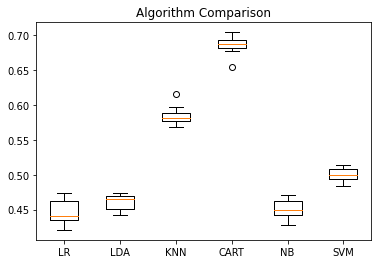

In [51]:
# Split-out validation dataset
array = ESG_ML.values
X = array[:,3:]
y = array[:,1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=24, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')

In [52]:
# Make predictions on validation dataset
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6807286673058485
[[481  63   6  12  26  70   2]
 [ 64 398  22   5   6  23   0]
 [  9  14  96   0   1   2   0]
 [ 14   2   0 244  81  39  34]
 [ 36   7   0  89 374  70  12]
 [ 76  35   2  35  77 441   1]
 [  0   0   0  30  26   8  96]]
              precision    recall  f1-score   support

           A       0.71      0.73      0.72       660
          AA       0.77      0.77      0.77       518
         AAA       0.76      0.79      0.77       122
           B       0.59      0.59      0.59       414
          BB       0.63      0.64      0.63       588
         BBB       0.68      0.66      0.67       667
         CCC       0.66      0.60      0.63       160

    accuracy                           0.68      3129
   macro avg       0.68      0.68      0.68      3129
weighted avg       0.68      0.68      0.68      3129



**Test models to see which is the best predictor using only Environmental and Social scores to predict Rating**

LR: 0.275028 (0.011816)
LDA: 0.268876 (0.013696)
KNN: 0.261207 (0.009373)
CART: 0.312102 (0.012582)
NB: 0.270874 (0.013401)
SVM: 0.276628 (0.010766)


Text(0.5, 1.0, 'Algorithm Comparison')

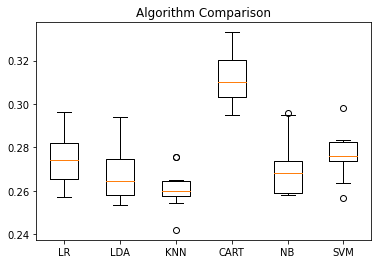

In [53]:
# Split-out validation dataset
array = ESG_ML.values
X = array[:,3:4]
y = array[:,1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=24, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=24, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')

**Test models to see which is the best predictor using only Environmental and Governance scores to predict Rating**

LR: 0.374834 (0.016483)
LDA: 0.374994 (0.015316)
KNN: 0.500599 (0.014958)
CART: 0.537594 (0.012616)
NB: 0.373475 (0.014798)
SVM: 0.388736 (0.013513)


Text(0.5, 1.0, 'Algorithm Comparison')

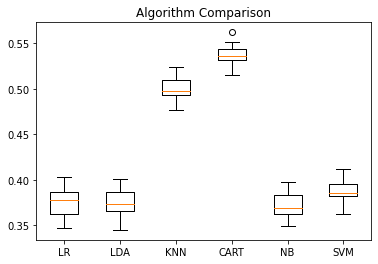

In [54]:
# Split-out validation dataset
array = ESG_ML.values
X = array[:,[3,5]]
y = array[:,1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=24, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')

**Test models to see which is the best predictor using only Social and Governance scores to predict Rating**

LR: 0.293409 (0.007646)
LDA: 0.304675 (0.009085)
KNN: 0.261448 (0.017831)
CART: 0.314826 (0.012693)
NB: 0.297643 (0.011310)
SVM: 0.306116 (0.011818)


Text(0.5, 1.0, 'Algorithm Comparison')

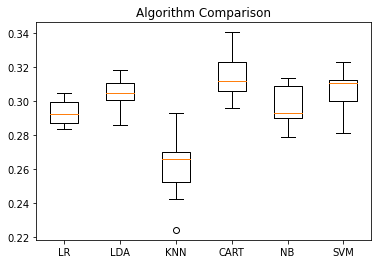

In [55]:
# Split-out validation dataset
array = ESG_ML.values
X = array[:,4:5]
y = array[:,1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=24, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')